#### IMPORT

In [1]:
import time
import pandas as pd
import os
import pyperclip as pc
import pyautogui 
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

#### FUNÇÕES 

In [12]:
def Converte_int(value): #Função para converter valores percentuais que para INT
    if isinstance(value, str):
        try:
            return int(value.replace('%', '')) # Remove '%' e converte para inteiro
        except ValueError:
            return pd.NA
    elif isinstance(value, (int, float)):
        return int(value)
    else:
        return pd.NA
    
def Adicionar_valores(ax, valores): #Função para adicionar valores acima das barras nos graficos
    for i, valor in enumerate(valores):
        texto = f'{valor:.2f}'
        ax.text(i, valor, texto, ha='center', va='bottom')

def Time_isolado(org, tabela): #Função que cria graficos que mostram as estastisticas de um determinado time 
    dados_org = tabela[tabela['TIME'] == org]
    media_org = dados_org.mean(numeric_only=True)
    jogador_r = dados_org.groupby('PLAYER')['R'].sum()
    jogador_kd = dados_org.groupby('PLAYER')['KD'].sum()
    jogador_hs = dados_org.groupby('PLAYER')['HS'].sum()
    jogador_fk = dados_org.groupby('PLAYER')['FK'].sum()
    jogador_fd = dados_org.groupby('PLAYER')['FD'].sum()

    print(f'Status em média do time da {org}\n')

    for coluna, valor in media_org.items():
        if coluna == 'KMAX':
            print(f'{coluna}: {dados_org[coluna].max()}')
        elif coluna == 'RND':
            pass
        else:
            print(f'{coluna}: {valor:.2f}')

    mosaico = 'ABC;DDE'
    fig = plt.figure(figsize=(15, 10))
    espaco = {'wspace': 0.3, 'hspace': 0.3}
    axs = fig.subplot_mosaic(mosaico, gridspec_kw=espaco)

    cores = plt.get_cmap('Dark2').colors

    axs['A'].bar(jogador_r.index, jogador_r.values, color=cores)
    axs['A'].set_title('RATING', fontsize=12)
    Adicionar_valores(axs['A'], jogador_r.values)
    axs['A'].tick_params(axis='both', length=0, labelsize='10')
    axs['A'].tick_params(axis='x', rotation=40) 
    axs['A'].spines['top'].set_visible(False)
    axs['A'].spines['right'].set_visible(False)

    axs['B'].bar(jogador_kd.index, jogador_kd.values, color=cores)
    axs['B'].set_title('KD (Kill/Death)', fontsize=12)
    Adicionar_valores(axs['B'], jogador_kd.values)
    axs['B'].tick_params(axis='both', length=0, labelsize='10')
    axs['B'].tick_params(axis='x', rotation=40) 
    axs['B'].spines['top'].set_visible(False)
    axs['B'].spines['right'].set_visible(False)

    axs['C'].bar(jogador_hs.index, jogador_hs.values, color=cores)
    axs['C'].set_title('HS %', fontsize=12)
    Adicionar_valores(axs['C'], jogador_hs.values)
    axs['C'].tick_params(axis='both', length=0, labelsize='10')
    axs['C'].tick_params(axis='x', rotation=40) 
    axs['C'].spines['top'].set_visible(False)
    axs['C'].spines['right'].set_visible(False)

    axs['D'].pie(jogador_fk, labels=[f'{jogador}: {value:.2f}' for jogador, value, in jogador_fk.items()], autopct='%1.1f%%')
    axs['D'].set_title('FK (First Kill)', fontsize=12)

    axs['E'].pie(jogador_fd, labels=[f'{jogador}: {value:.2f}' for jogador, value, in jogador_fd.items()], autopct='%1.1f%%')
    axs['E'].set_title('FD (First Death)', fontsize=12)
    
    plt.tight_layout(pad=2.0)

    fig.suptitle(f'Estatisticas do time da {org}', fontsize=16)
    plt.show()

def Times_comparado(numero, tabela): #Função que cria graficos para comparar as estastisticas entre times
    orgs = []
    medias = { 'R': [], 'KD': [], 'HS': [], 'CL': [] }

    for i in range(numero):
        org = input(f'Qual o {i+1}º time?').upper()
        orgs.append(org)
        dados_org = tabela[tabela['TIME'] == org]
        for key in medias.keys():
            medias[key].append(dados_org[key].mean())

    cores = plt.get_cmap('Dark2').colors
    mosaico = 'AB;CD'
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 11), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

    for ax, (key, values) in zip(axs.flat, medias.items()):
        ax.bar(orgs, values, color=cores)
        ax.set_title(f'{key}', fontsize=12)
        Adicionar_valores(ax, values)
        ax.tick_params(axis='both', length=0, labelsize='10')
        ax.tick_params(axis='x', rotation=40)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

def Player_dados(jogador, tabela): #Função que mostra as estastisticas de um determinado player
    jogador = jogador.upper()
    lista_jogador = tabela[tabela['PLAYER'] == jogador]
    print(lista_jogador.iloc[0])

def Player_comparado(numero, tabela): #Função que cria um grafico que demonstra as estastisticas entre players
    player_index = tabela.set_index('PLAYER')
    jogadores = [input(f'{i+1}º jogador?').upper() for i in range(numero)]

    dados_jogadores = { key: player_index.loc[jogadores, key] for key in ['R', 'KD', 'KAST', 'HS', 'KMAX', 'CL', 'FK', 'FD'] }

    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 22), gridspec_kw={'wspace': 0.15, 'hspace': 0.23})
    cores = plt.get_cmap('Dark2').colors

    for ax, (key, values) in zip(axs.flat, dados_jogadores.items()):
        ax.bar(jogadores, values, color=cores)
        ax.set_title(f'{key}', fontsize=12)
        Adicionar_valores(ax, values)
        ax.tick_params(axis='both', length=0)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.show()

def Dados_especificos(acao_dado, tabela): #Exibe um gráfico de barras com médias de um dado específico para os times.
    numero_dado = int(input('Quantos times deseja comparar? (MAX 15)'))
    cores = plt.get_cmap('Dark2').colors
    status_times = tabela.groupby('TIME')[acao_dado].mean()
    status_times_ordenado = status_times.sort_values(ascending=False)

    plt.figure(figsize=(11, 6))
    grafico = status_times_ordenado[:numero_dado].plot(kind='bar', color=cores)
    plt.title(f'TOP {numero_dado} TIMES EM {acao_dado}', fontweight='bold')
    plt.tick_params(axis='both', length=0)
    plt.xticks(rotation=40)
    Adicionar_valores(grafico, status_times_ordenado[:numero_dado])
    plt.show()

#### ABRIR TABELA E CONVERTER VALORES

In [10]:
status = pd.read_excel("stats_completo.xlsx") #Selecionando quais dados serão covertidos para INT
status['HS'] = status['HS'].str.replace('%', '').apply(Converte_int)
status['KAST'] = status['KAST'].str.replace('%', '').apply(Converte_int)
status['CL'] = status['CL'].apply(Converte_int)
status['PLAYER'] = status['PLAYER'].str.upper()

AttributeError: 'float' object has no attribute 'replace'

#### MENU DE USO

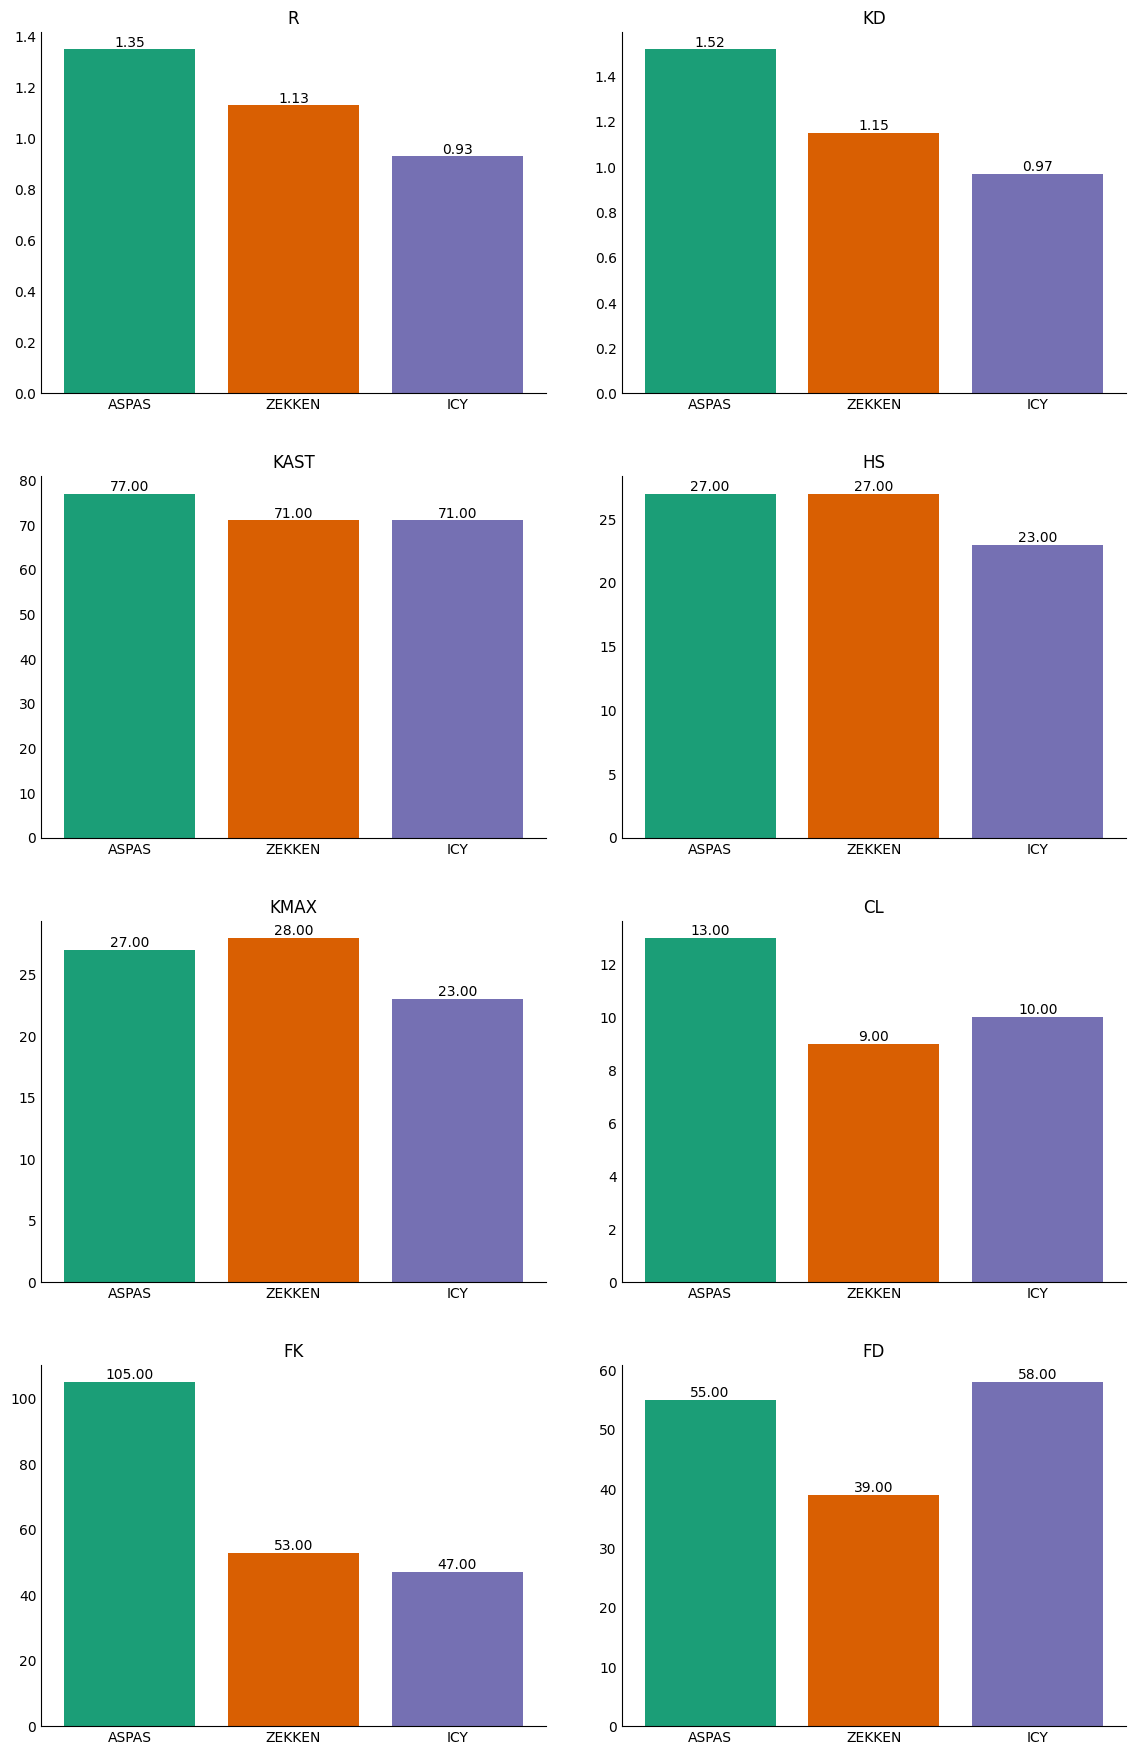

In [ ]:
acao = int(input('O que deseja pesquisar?\n1. Dados de Time\n2. Comparar dados entre times\n3. Visualizar dados de um player\n4. Comparar dados entre players\n5. Usar um dado como parametro entre times\n'))

if acao == 1:
    org = input('Qual time?').upper()
    Time_isolado(org, status)
    
elif acao == 2:
    numero = int(input('Quantos times deseja comparar?'))
    Times_comparado(numero, status)

elif acao == 3:
    player = input('Qual player?')
    Player_dados(player, status)
        
elif acao == 4:
    numero = int(input('Quantos players deseja comparar?'))
    Player_comparado(numero, status)

elif acao == 5:
    acao_dado = input('Qual dado deseja pesquisar?').upper()
    Dados_especificos(acao_dado, status)
